In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re

In [ ]:
!unzip preproc_Datasets.zip

Archive:  preproc_Datasets.zip
   creating: preproc_Datasets/
   creating: preproc_Datasets/datasets_slide/
  inflating: preproc_Datasets/datasets_slide/dataset_raw10.csv  
  inflating: preproc_Datasets/datasets_slide/dataset_raw15.csv  
  inflating: preproc_Datasets/datasets_slide/dataset_raw9.csv  
  inflating: preproc_Datasets/datasets_slide/dataset_raw11.csv  
  inflating: preproc_Datasets/datasets_slide/dataset_raw13.csv  
  inflating: preproc_Datasets/datasets_slide/dataset_raw14.csv  
  inflating: preproc_Datasets/datasets_slide/dataset_raw4.csv  
 extracting: preproc_Datasets/datasets_slide/dataset_raw12.csv  
  inflating: preproc_Datasets/datasets_slide/dataset_raw7.csv  
  inflating: preproc_Datasets/datasets_slide/dataset_raw1.csv  
  inflating: preproc_Datasets/datasets_slide/dataset_raw6.csv  
  inflating: preproc_Datasets/datasets_slide/dataset_raw16.csv  
  inflating: preproc_Datasets/datasets_slide/dataset_raw5.csv  
  inflating: preproc_Datasets/datasets_slide/dataset_

In [ ]:
DATA_DIR = Path("preproc_Datasets/datasets")      # при необходимости поменяйте путь
PATTERN   = "dataset_raw*.csv"            # шаблон имён файлов

names = ["t", "ax", "ay", "yawRate", "steer"]  # 6-я временная

def natural_key(p):                     # сортировка raw1, raw2, …
    parts = re.split(r"(\d+)", p.stem)
    return [int(s) if s.isdigit() else s for s in parts]

dfs_circle = []
for f in sorted(DATA_DIR.glob(PATTERN), key=natural_key):
    df = pd.read_csv(
        f,
        engine="python"     # терпимее к кривым строкам
    )
    dfs_circle.append(df)

In [ ]:
DATA_DIR = Path("preproc_Datasets/datasets_slide")      # при необходимости поменяйте путь
PATTERN   = "dataset_raw*.csv"            # шаблон имён файлов

names = ["t", "ax", "ay", "yawRate", "steer"]  # 6-я временная

def natural_key(p):                     # сортировка raw1, raw2, …
    parts = re.split(r"(\d+)", p.stem)
    return [int(s) if s.isdigit() else s for s in parts]

dfs_zanos = []
for f in sorted(DATA_DIR.glob(PATTERN), key=natural_key):
    df = pd.read_csv(
        f,
        engine="python"     # терпимее к кривым строкам
    )
    dfs_zanos.append(df)

In [ ]:
DATA_DIR = Path("preproc_Datasets/datasets_straight")      # при необходимости поменяйте путь
PATTERN   = "dataset_raw*.csv"            # шаблон имён файлов

names = ["t", "ax", "ay", "yawRate", "steer"]  # 6-я временная

def natural_key(p):                     # сортировка raw1, raw2, …
    parts = re.split(r"(\d+)", p.stem)
    return [int(s) if s.isdigit() else s for s in parts]

dfs_forward = []
for f in sorted(DATA_DIR.glob(PATTERN), key=natural_key):
    df = pd.read_csv(
        f,
        engine="python"     # терпимее к кривым строкам
    )
    dfs_forward.append(df)

In [ ]:
def plot_data(df):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    # угловое ускорение
    axs[0].plot(df["t_sec"], df["angular_accel"], color='tab:red')
    axs[0].set_title("Angular Acceleration")
    axs[0].set_xlabel("Time (s)")
    axs[0].set_ylabel("Angular Accel (deg/s²)")
    axs[0].grid(True)

    # траектория
    axs[1].plot(df["x_world"], df["y_world"], color='tab:blue')
    axs[1].set_title("Trajectory (World Frame)")
    axs[1].set_xlabel("X (m)")
    axs[1].set_ylabel("Y (m)")
    axs[1].axis('equal')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
def data_to_world_frame(df):
    # Время в секундах
    df["t_sec"] = df["t"] / 1000
    dt = df["t_sec"].diff().fillna(0.02).astype(float)  # подставим 20 мс, если NaN

    # Интеграция угла
    yaw = [0]
    for i in range(1, len(df)):
        dyaw = df["yawRate"].iloc[i] * dt.iloc[i]
        yaw.append(yaw[-1] + dyaw)
    df["yaw"] = yaw

    # Перевод угла в радианы
    df["yaw_rad"] = np.deg2rad(df["yaw"])

    # Поворот локального ускорения в мировую систему координат
    ax_world = []
    ay_world = []

    for i in range(len(df)):
        theta = df["yaw_rad"].iloc[i]
        ax = df["ax"].iloc[i]
        ay = df["ay"].iloc[i]

        ax_w = ax * np.cos(theta) - ay * np.sin(theta)
        ay_w = ax * np.sin(theta) + ay * np.cos(theta)

        ax_world.append(ax_w)
        ay_world.append(ay_w)

    df["ax_world"] = ax_world
    df["ay_world"] = ay_world

    df["angular_accel"] = df["yawRate"].diff() / dt
    df["angular_accel"] = df["angular_accel"].fillna(0).astype(float)

    # Интеграция для траектории
    vx, vy, x, y = [0], [0], [0], [0]
    for i in range(1, len(df)):
        dt_i = dt.iloc[i]
        vx_i = vx[-1] + df["ax_world"].iloc[i] * dt_i
        vy_i = vy[-1] + df["ay_world"].iloc[i] * dt_i
        vx.append(vx_i)
        vy.append(vy_i)
        x_i = x[-1] + vx_i * dt_i
        y_i = y[-1] + vy_i * dt_i
        x.append(x_i)
        y.append(y_i)
    df["x_world"] = x
    df["y_world"] = y

    plot_data(df)

    return df

In [ ]:
!mkdir -p data_in_world_frame/datasets
!mkdir -p data_in_world_frame/datasets_slide
!mkdir -p data_in_world_frame/datasets_straight

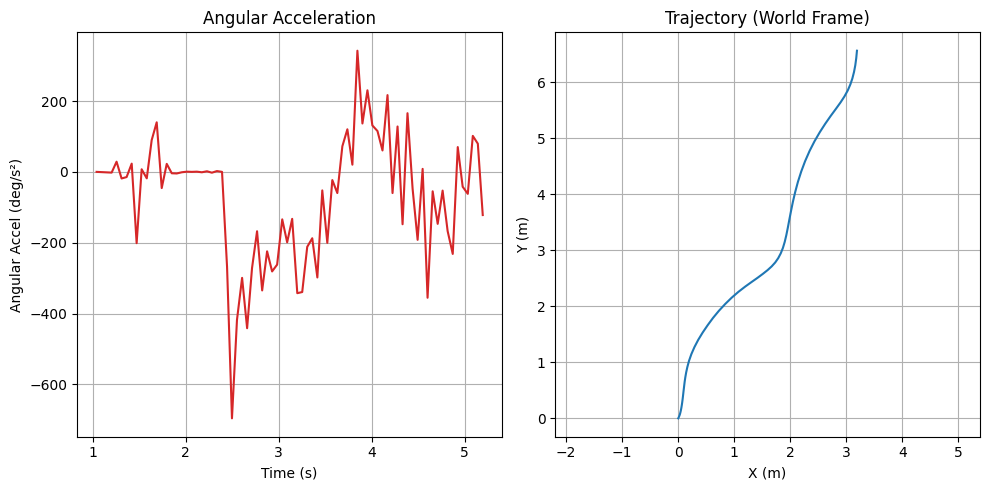

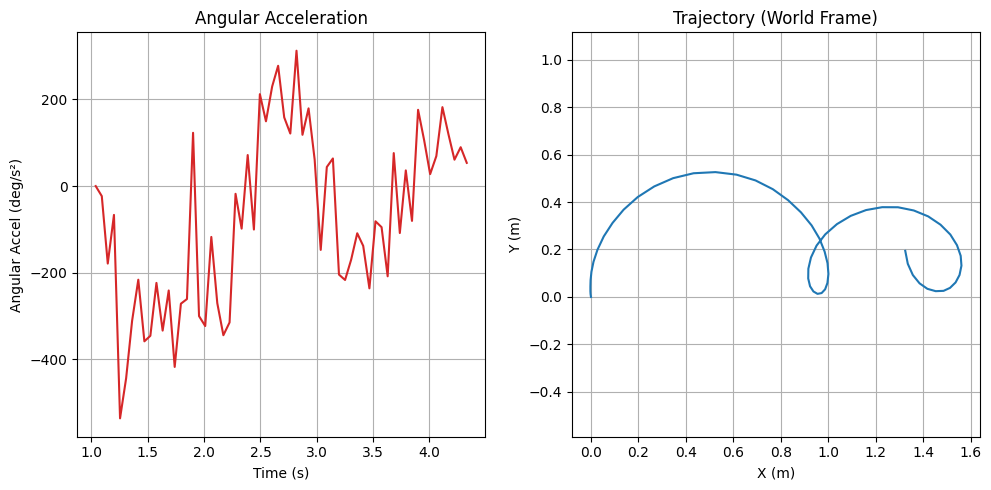

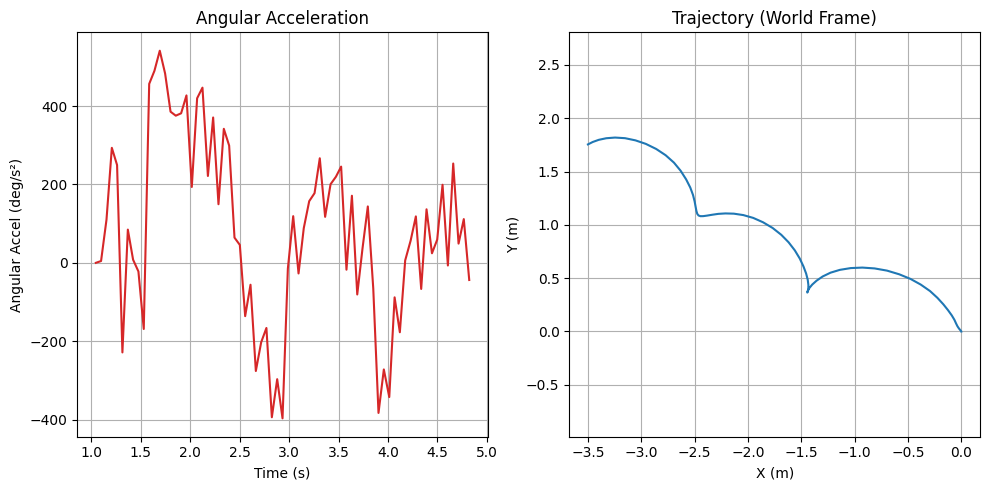

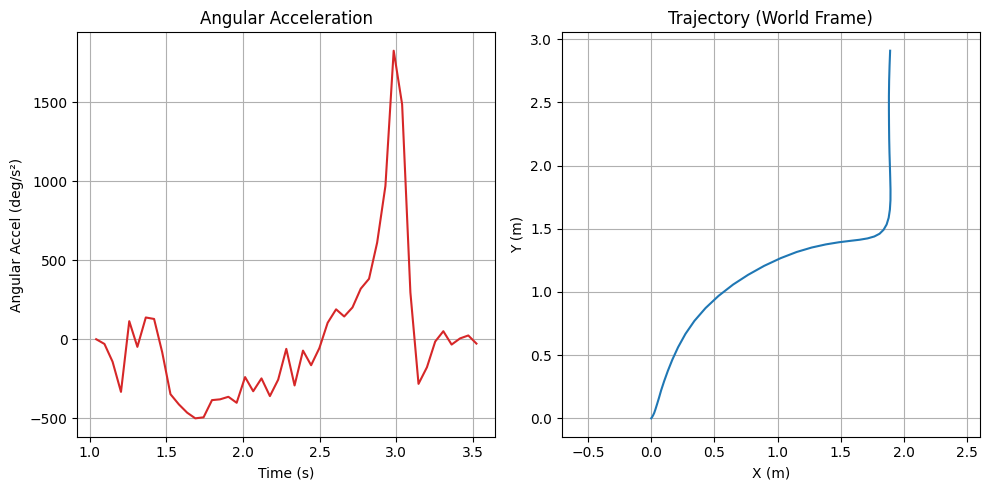

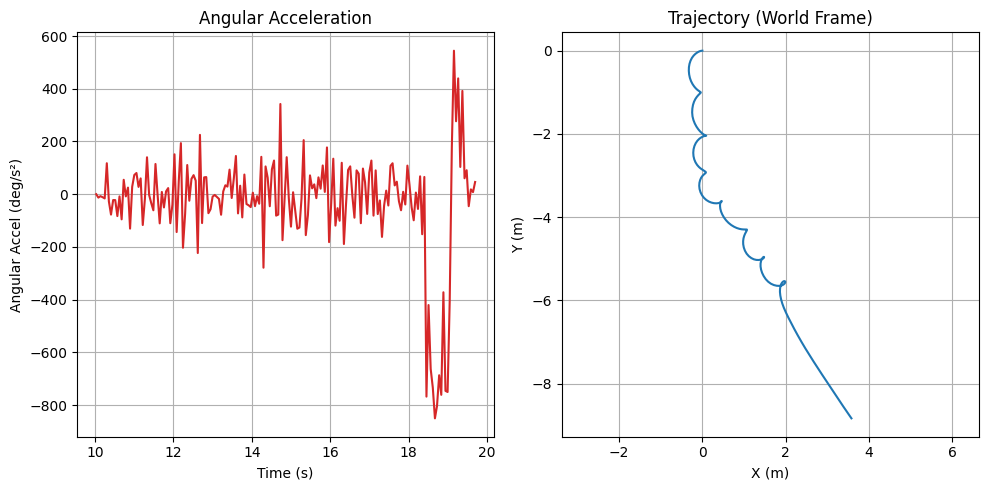

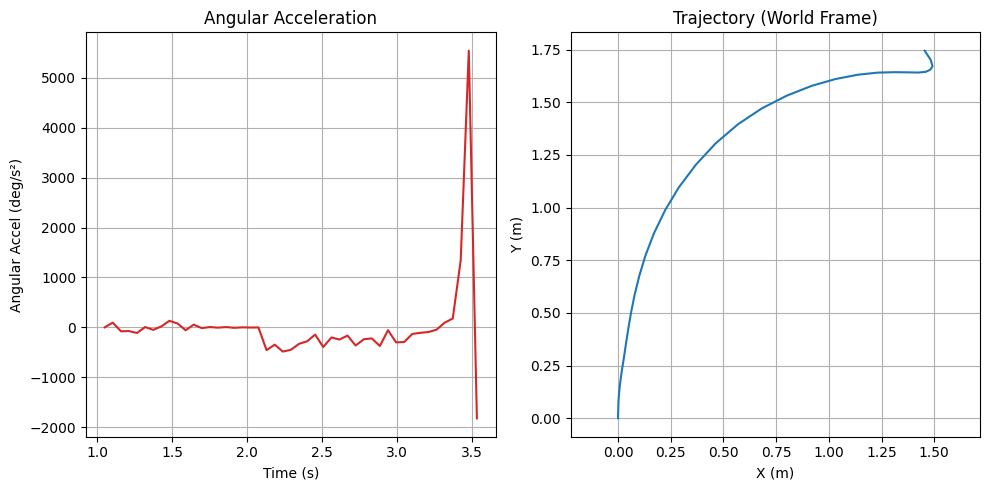

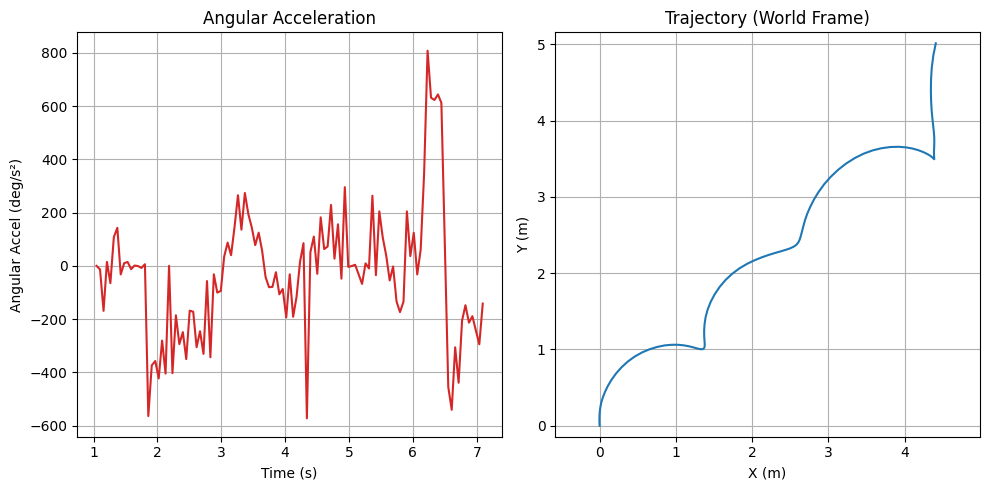

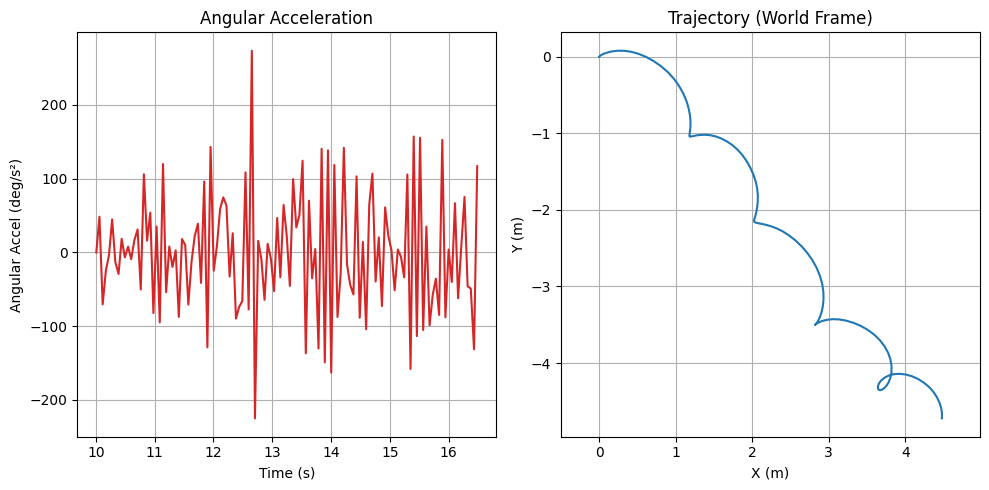

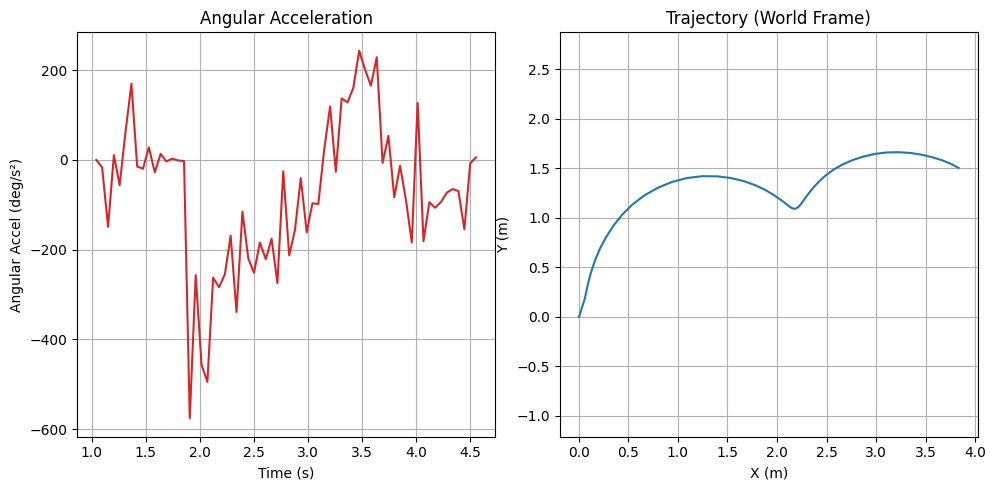

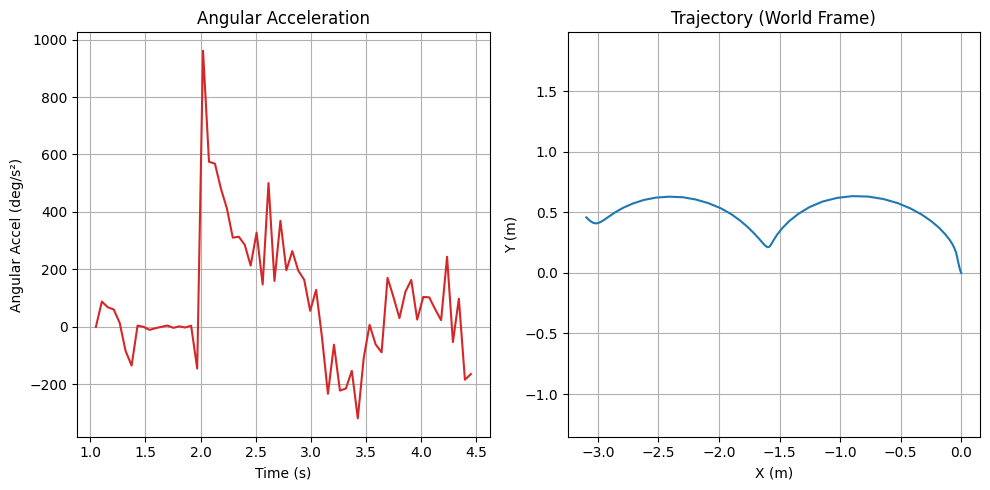

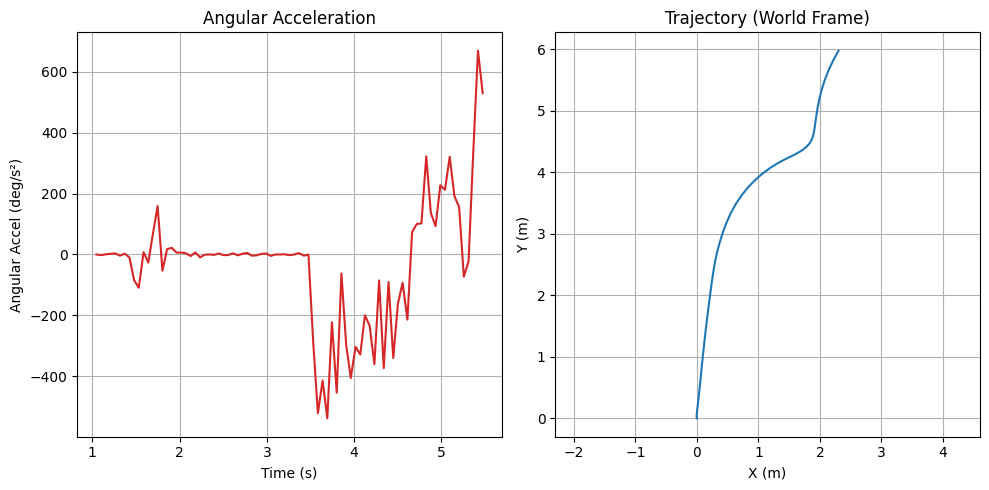

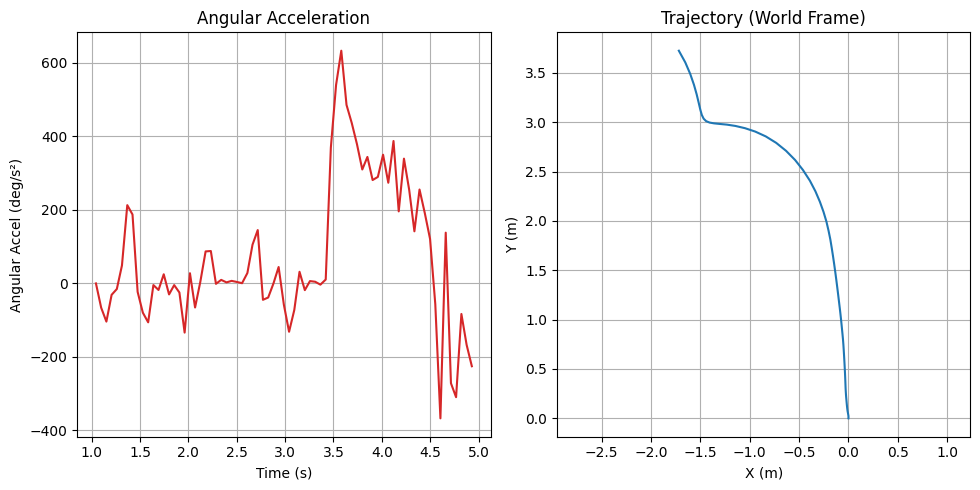

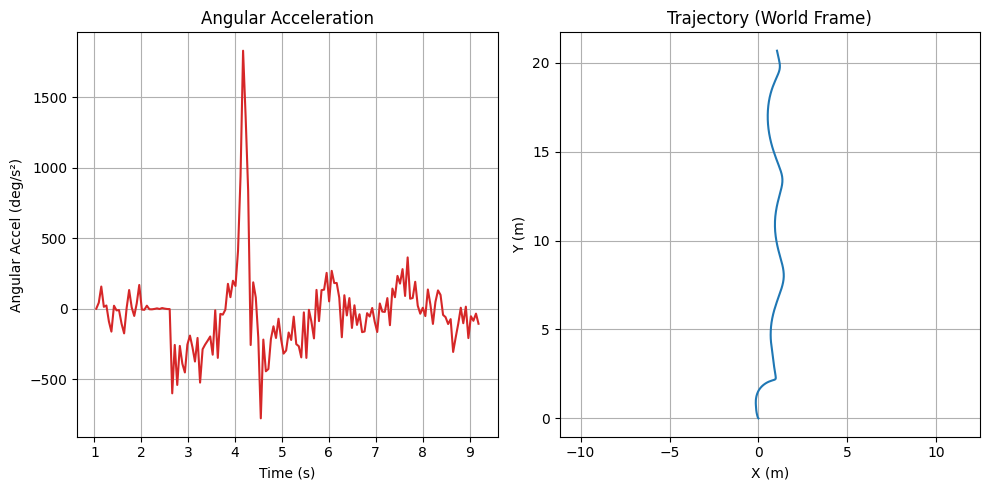

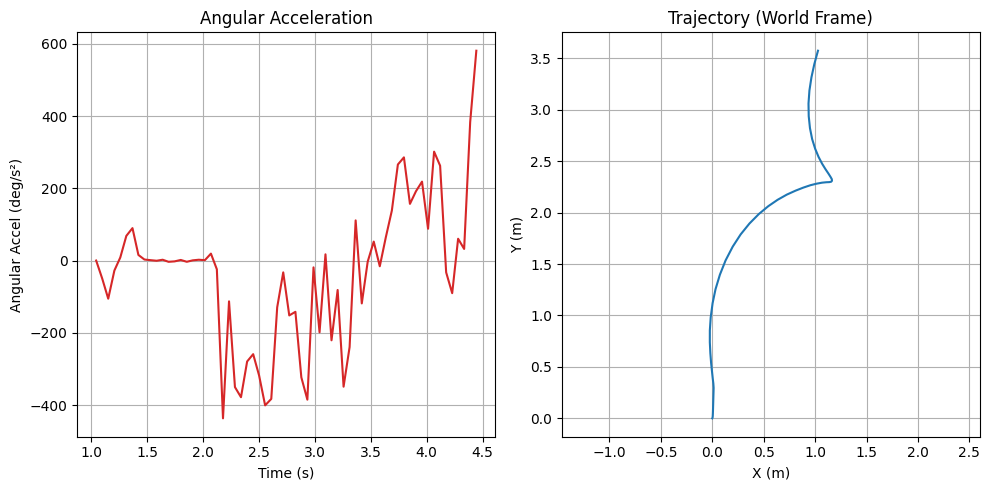

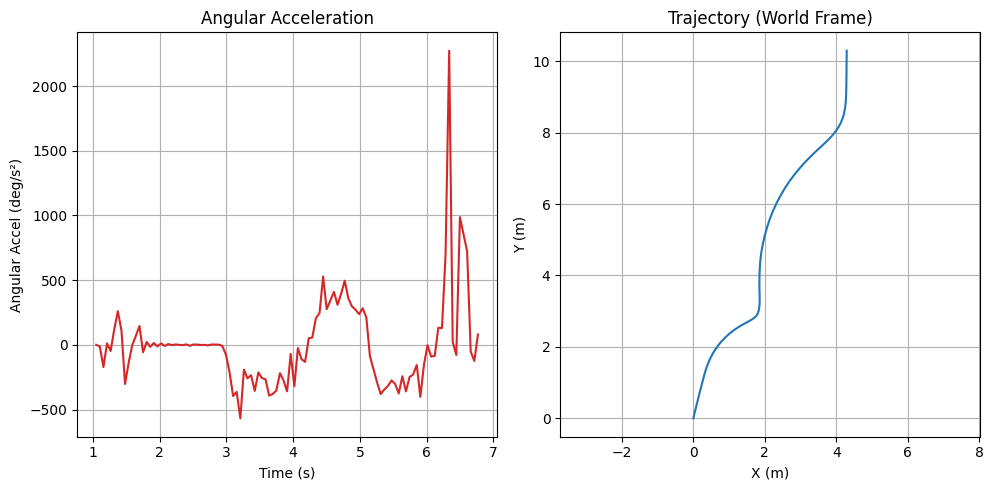

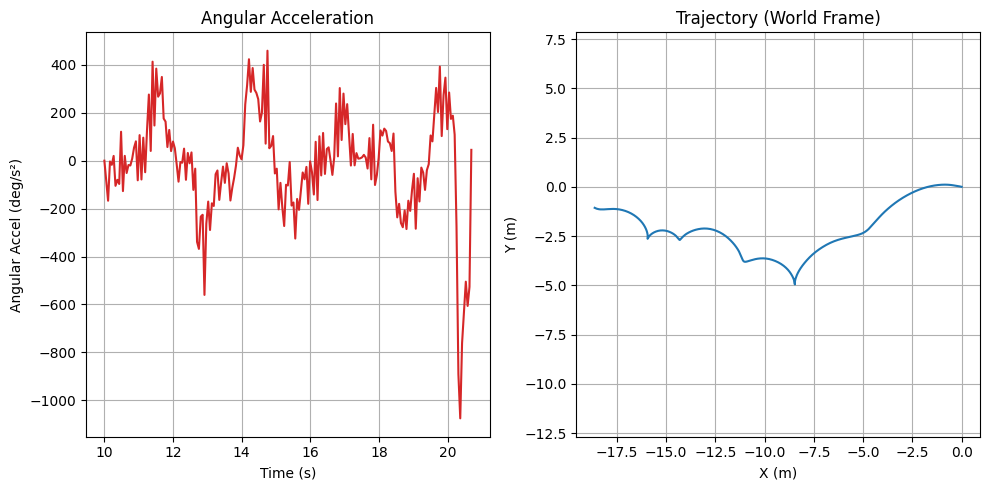

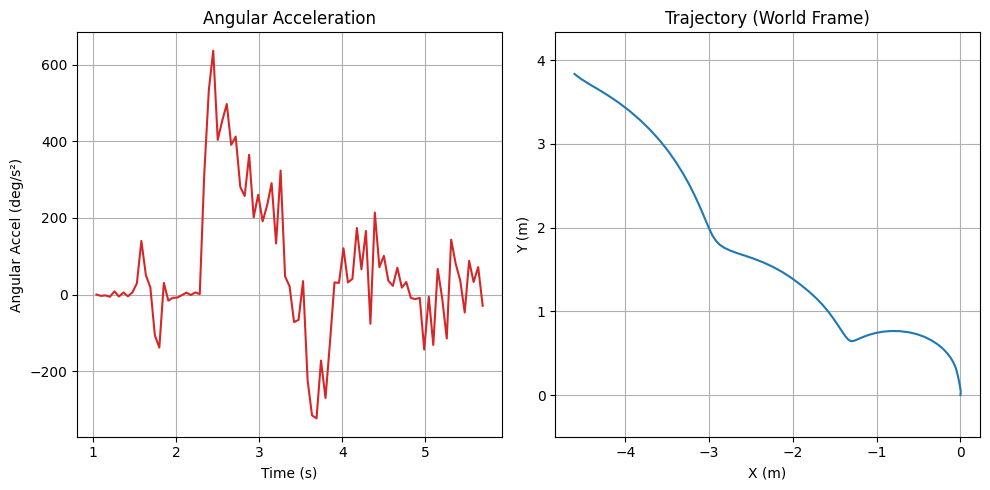

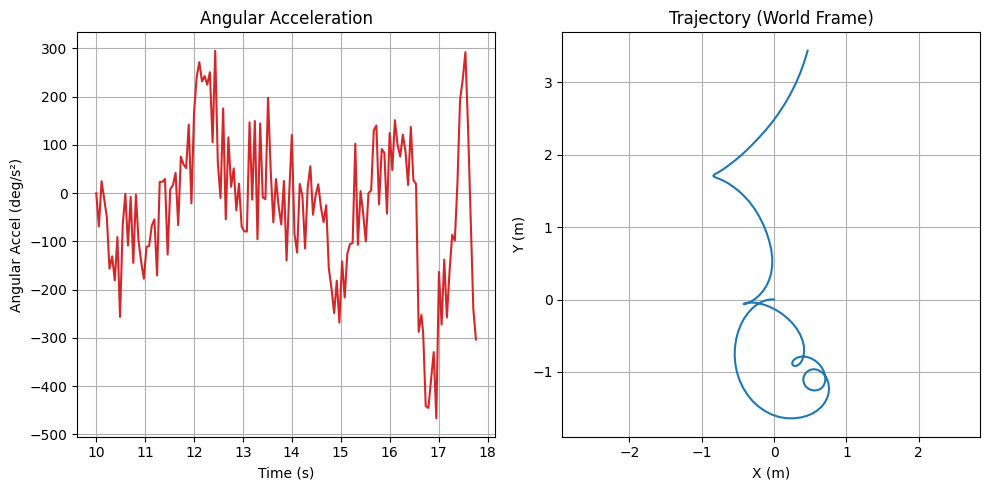

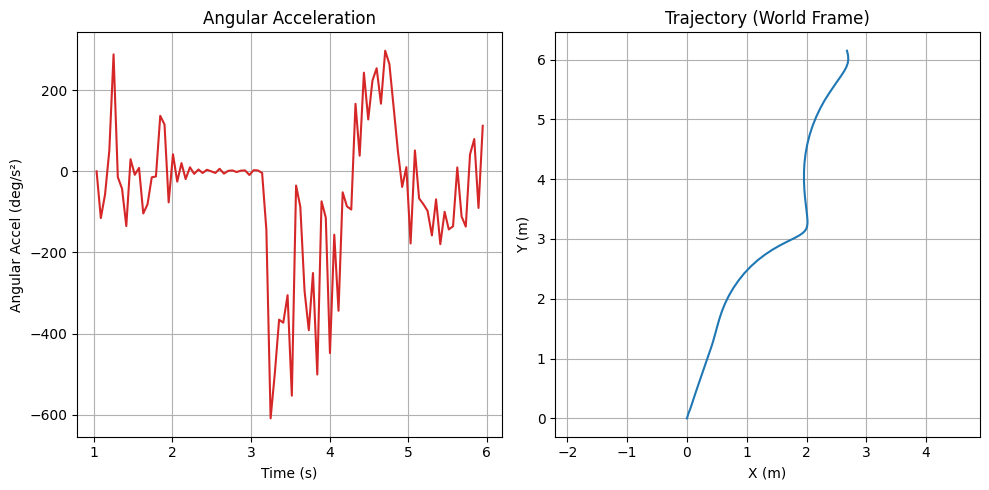

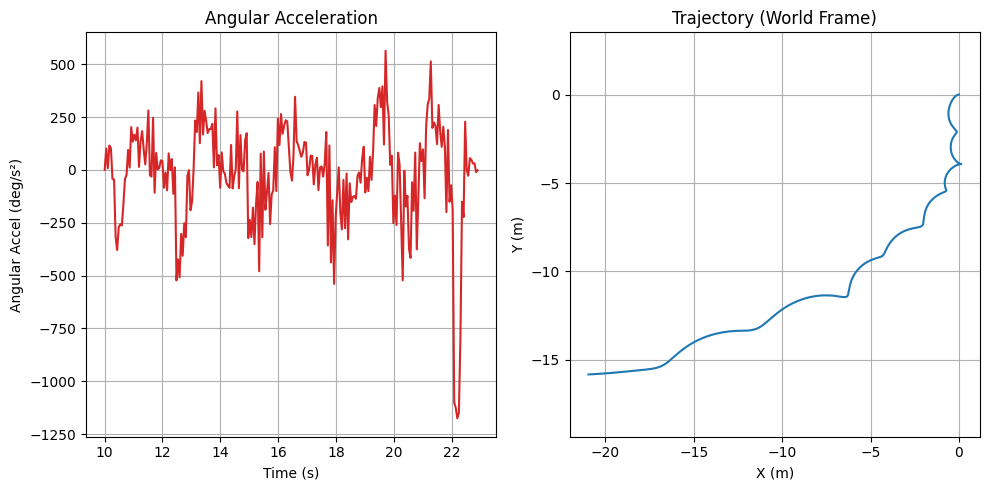

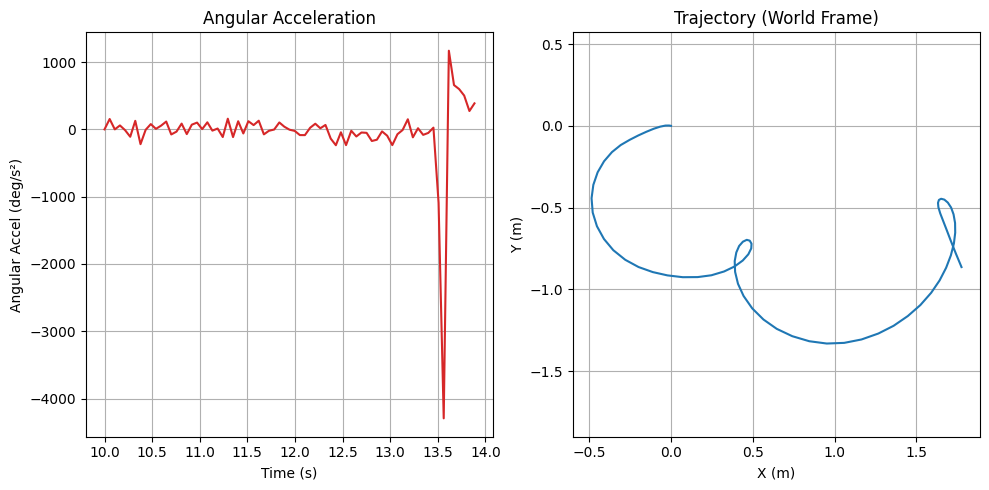

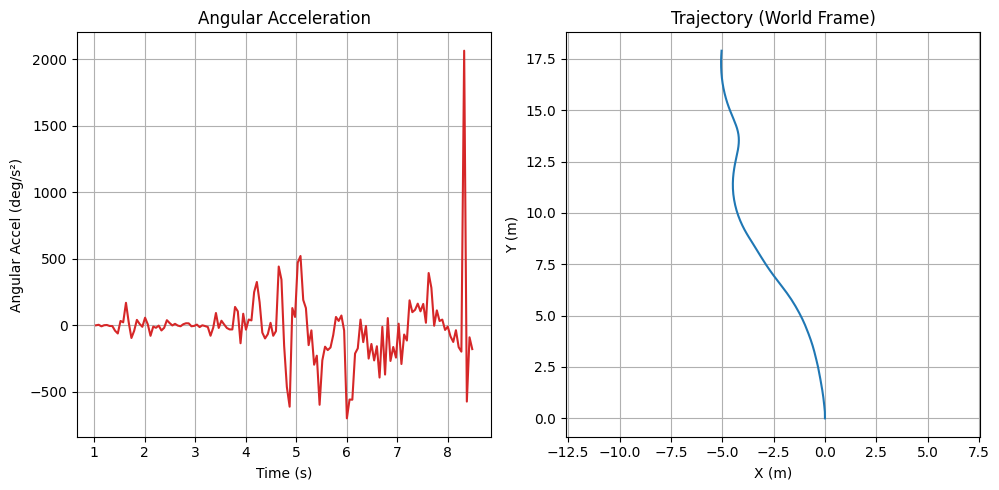

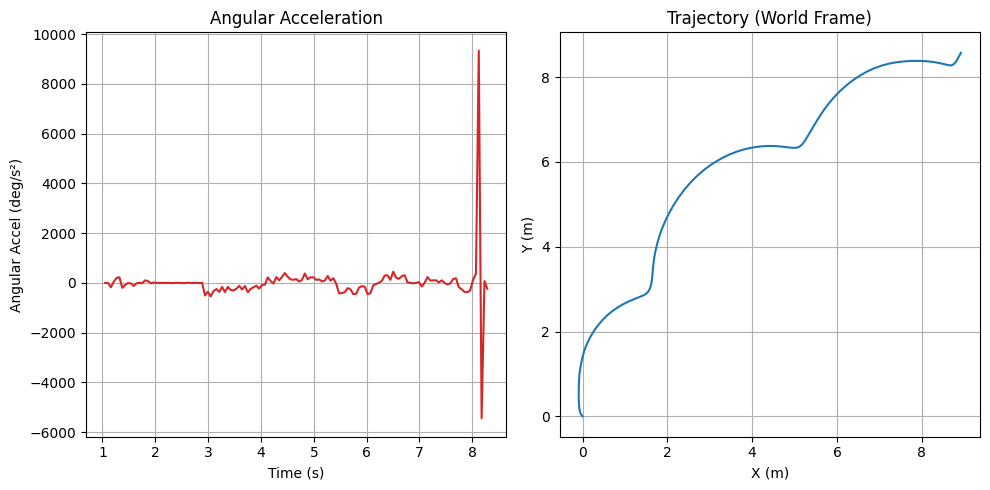

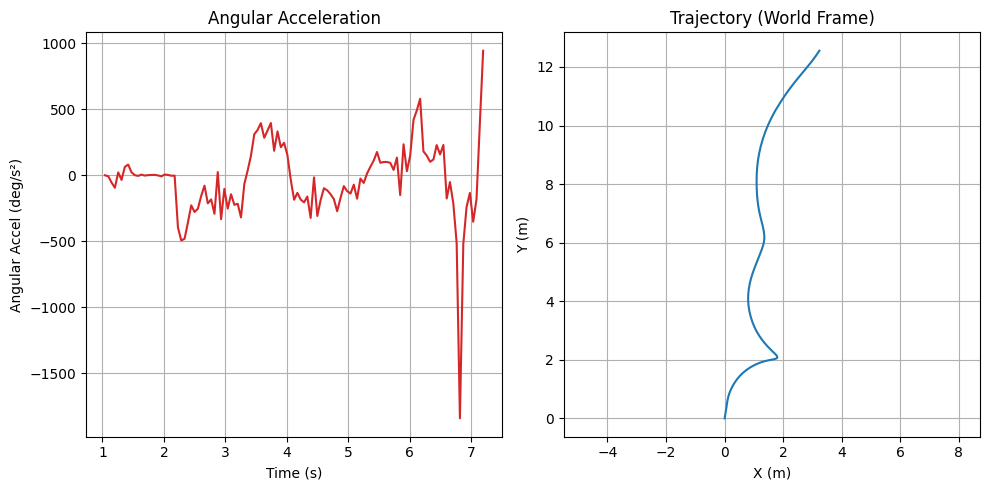

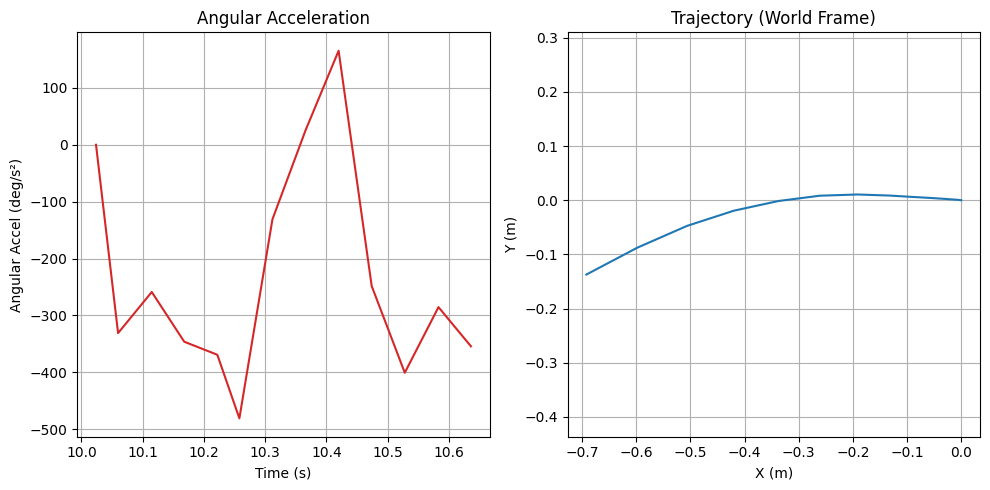

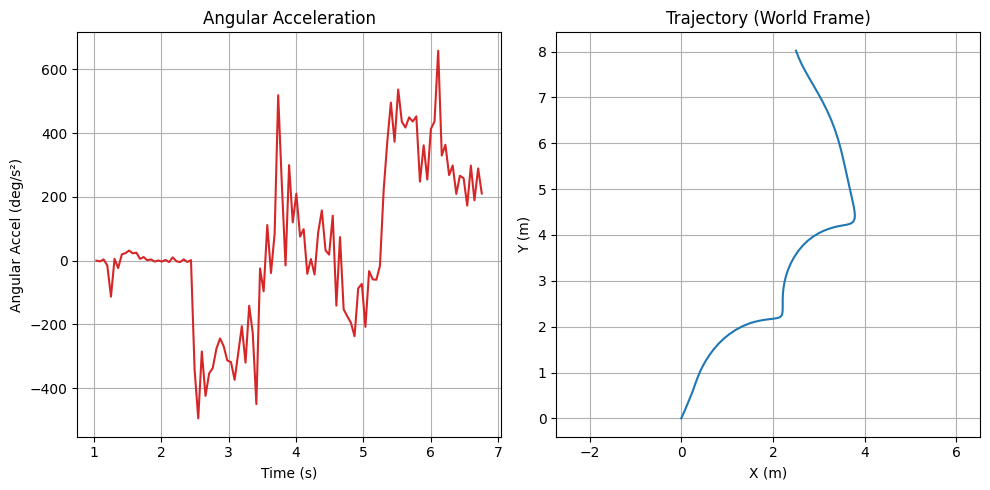

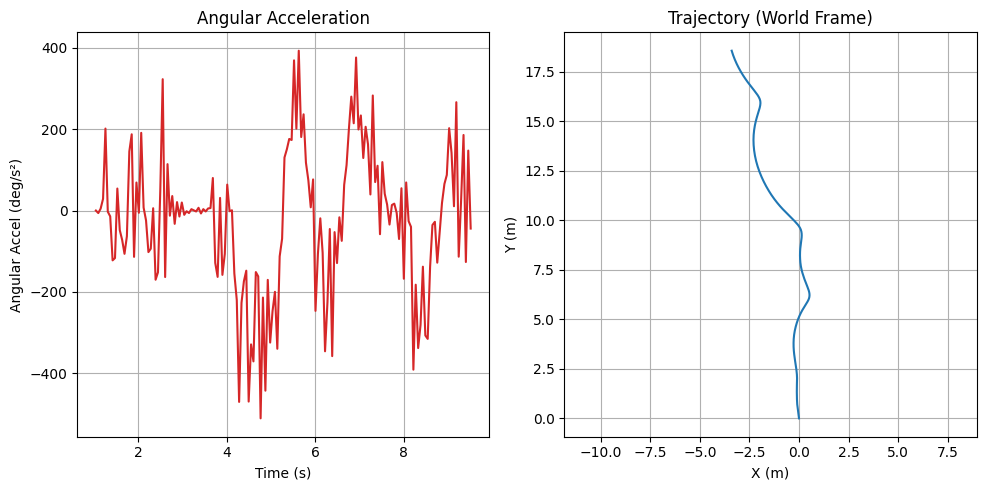

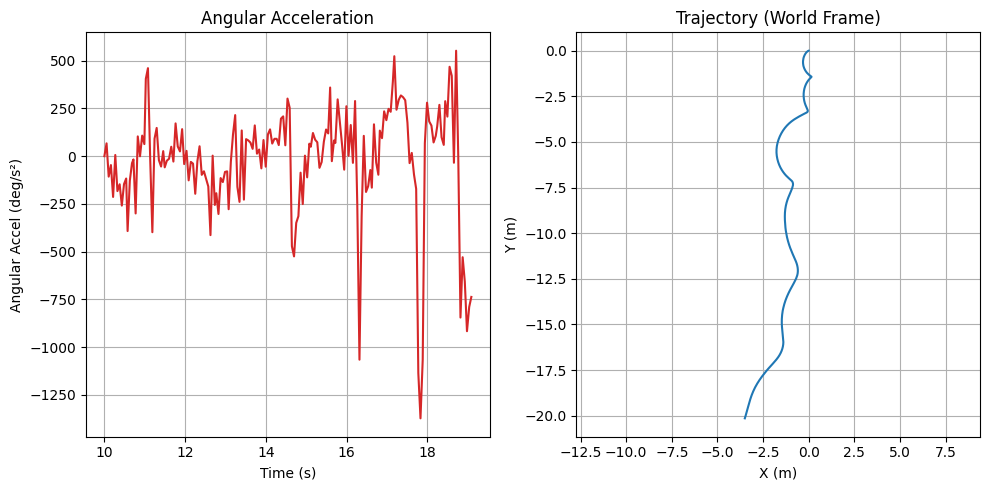

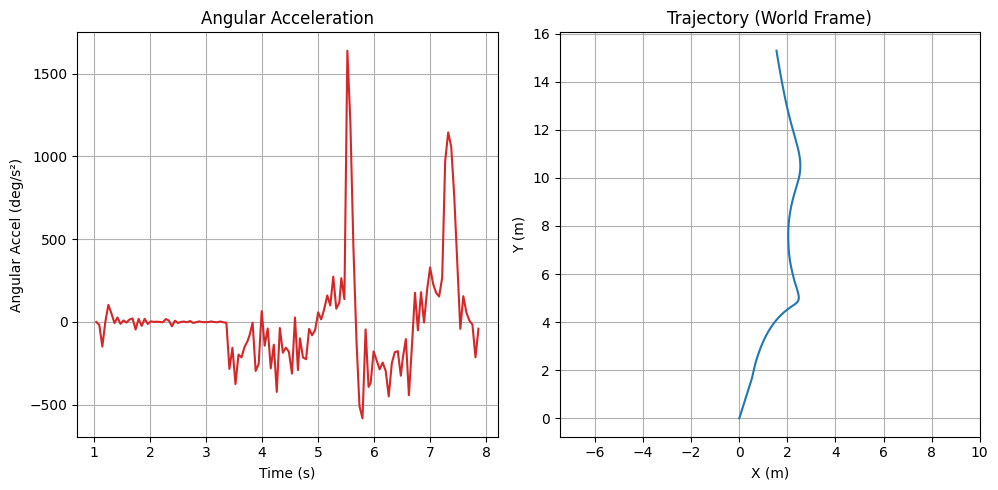

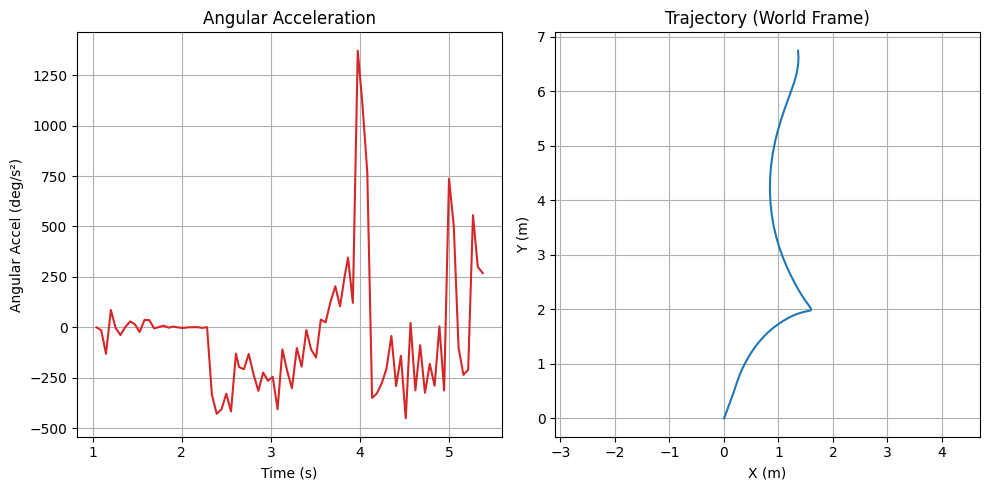

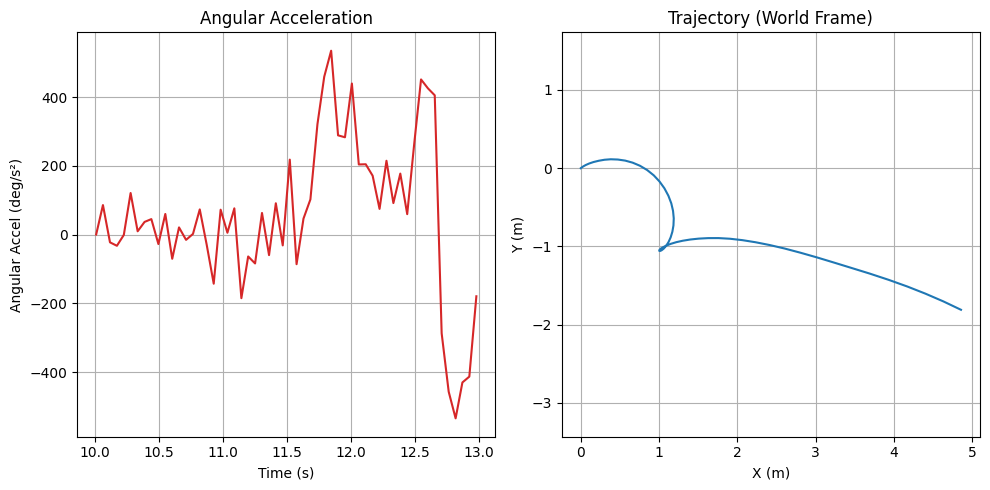

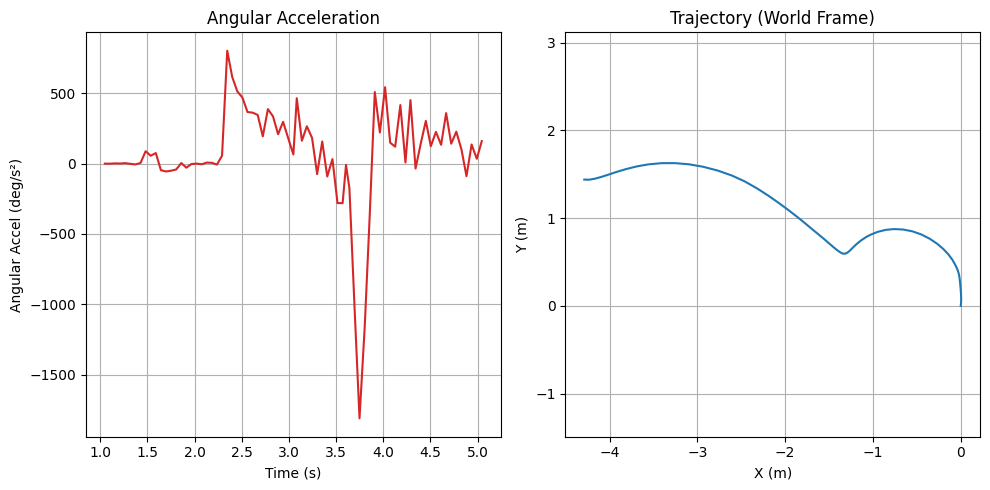

In [ ]:
n = 1
for df_i in dfs_circle:
    df_new = data_to_world_frame(df_i)
    df_new.to_csv(f'data_in_world_frame/datasets/dataset_raw{n}.csv', index=False)
    n += 1

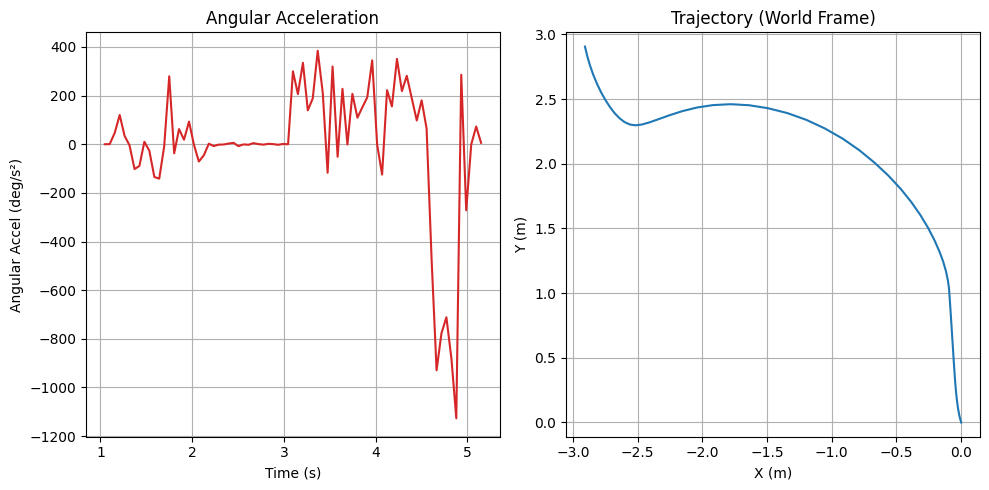

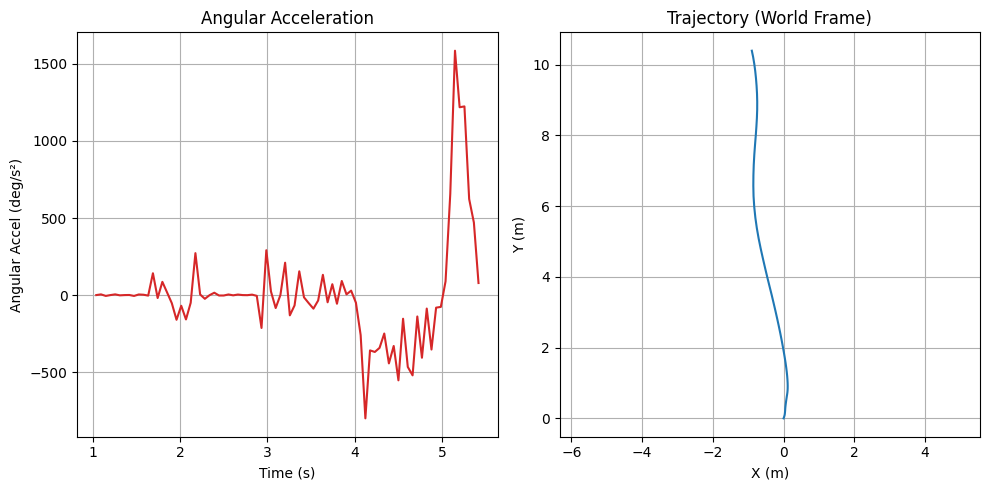

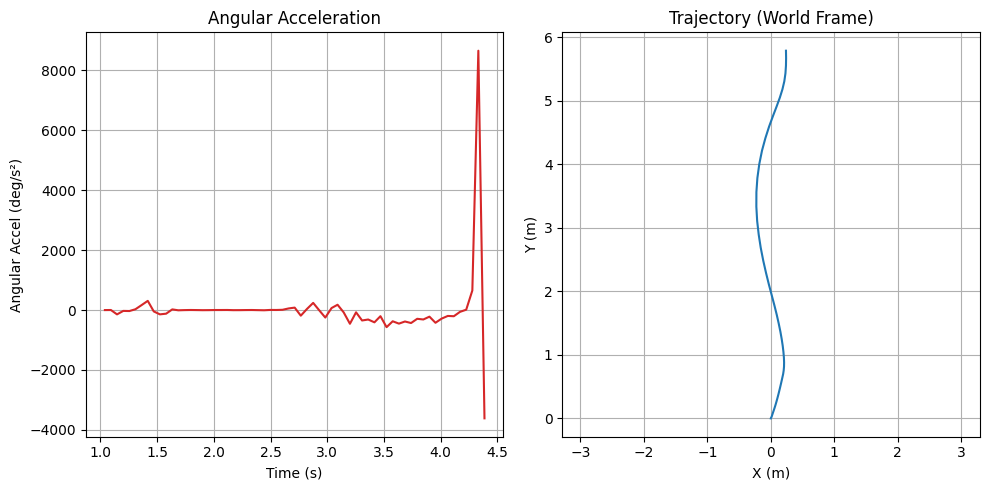

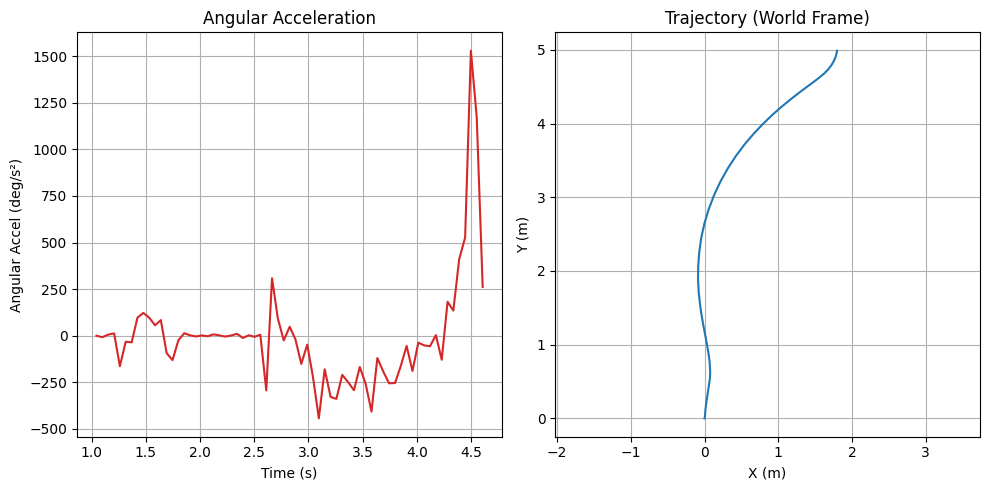

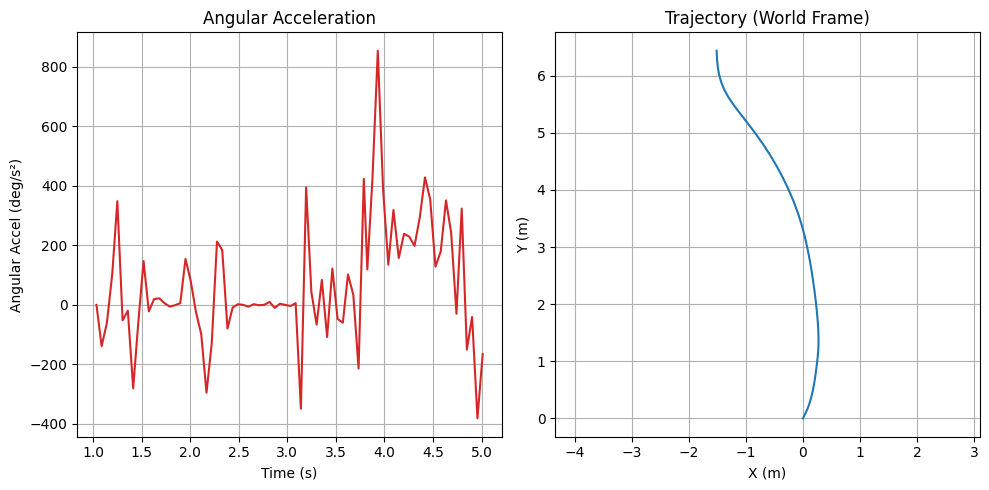

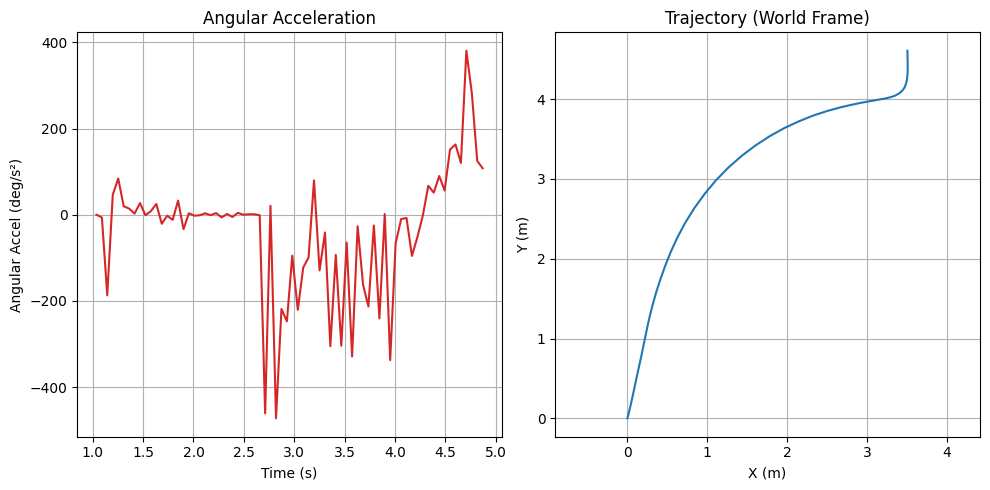

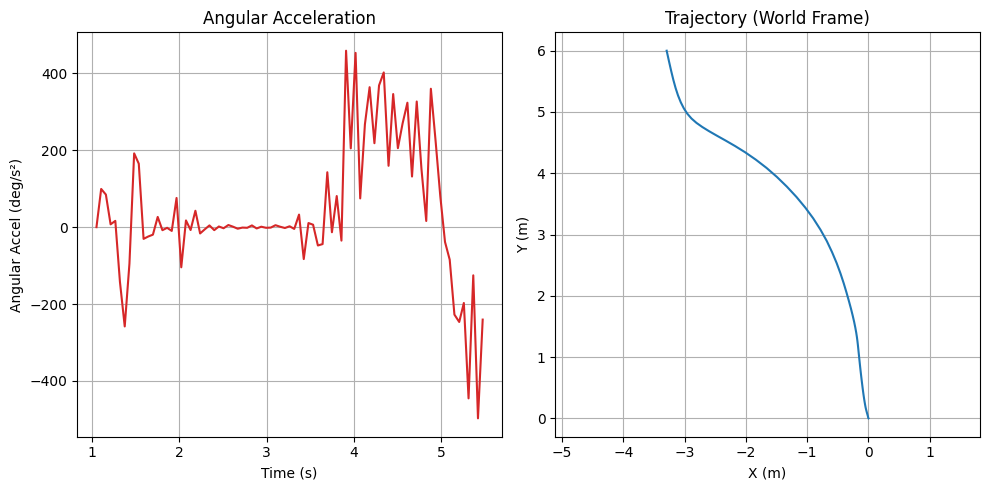

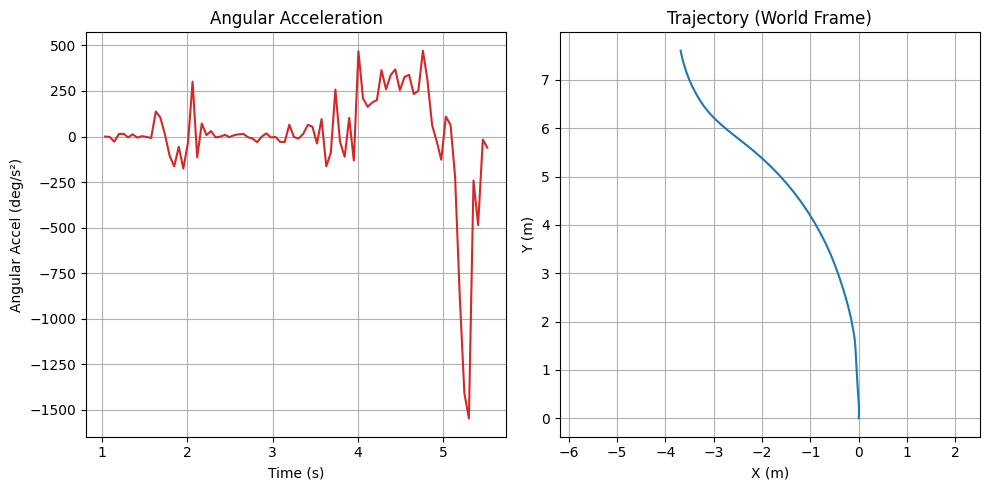

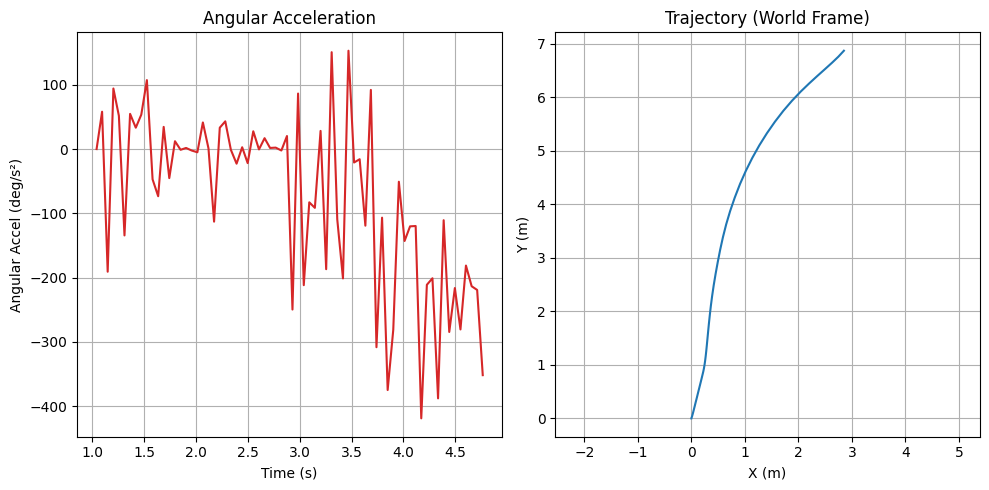

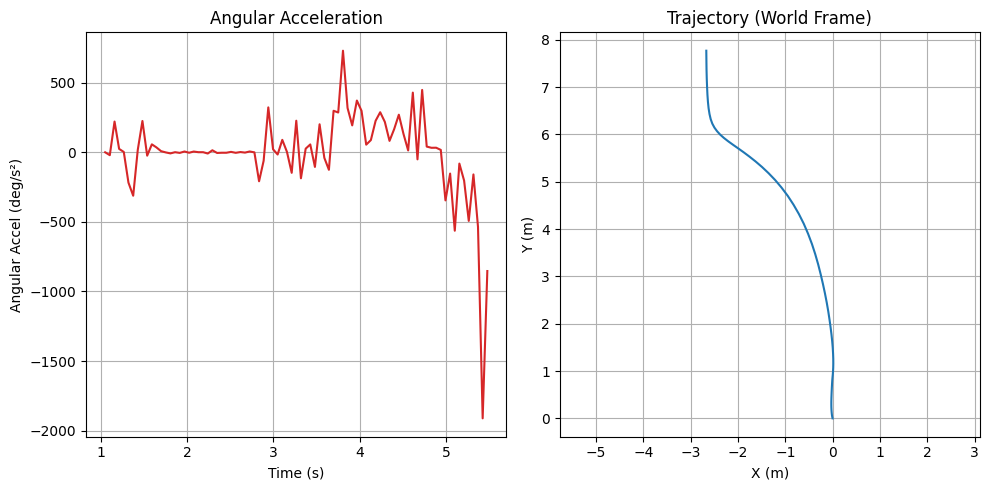

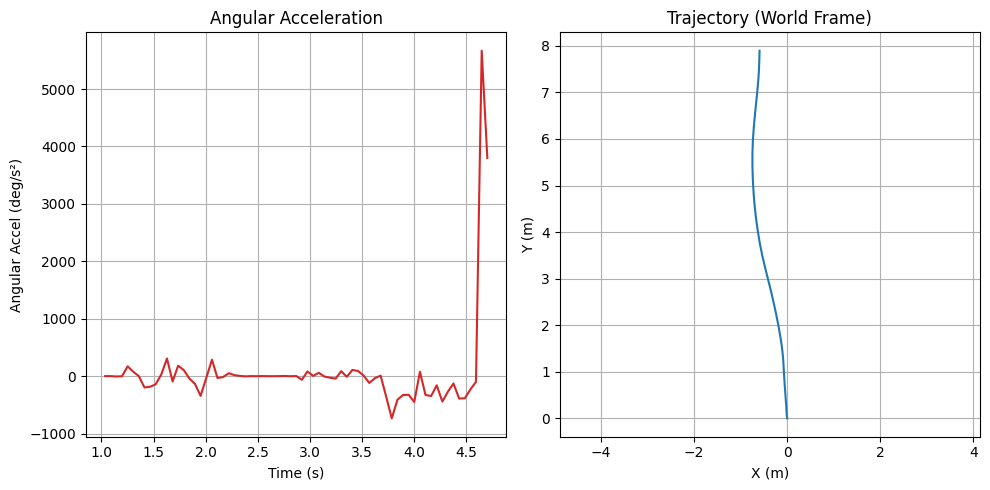

/tmp/ipython-input-29-3755987824.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dt = df["t_sec"].diff().fillna(0.02).infer_objects()  # подставим 20 мс, если NaN
/tmp/ipython-input-29-3755987824.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["angular_accel"] = df["angular_accel"].fillna(0).infer_objects()


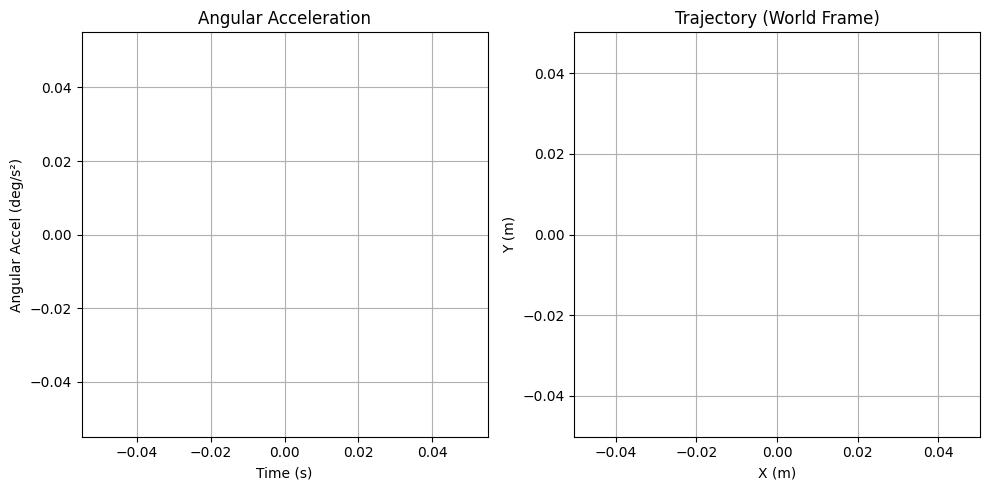

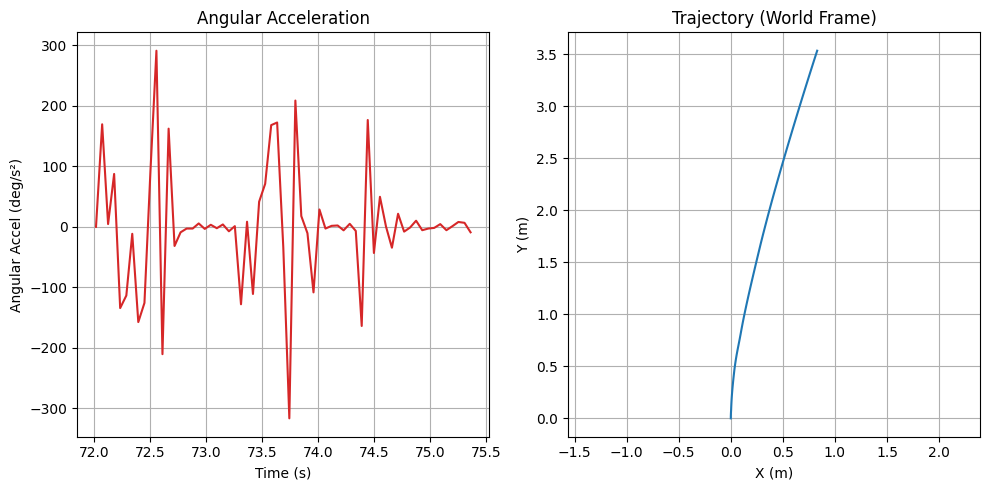

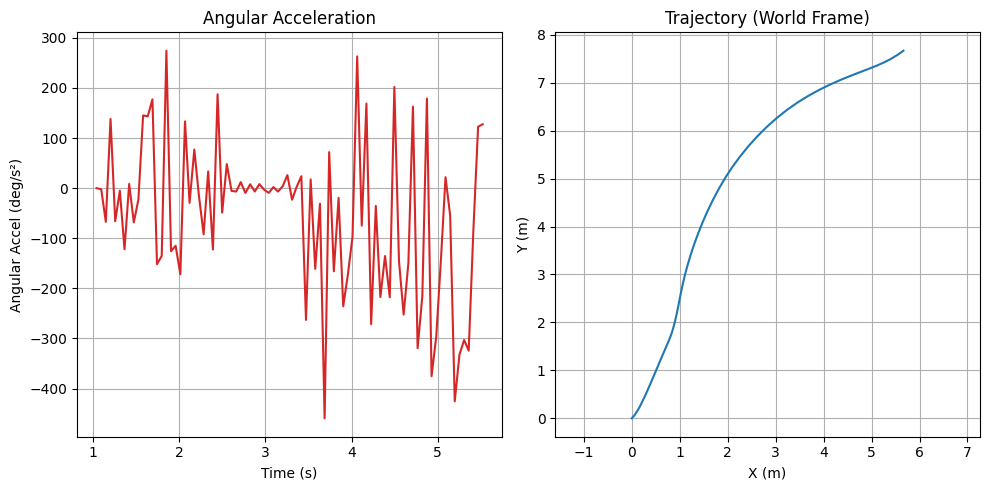

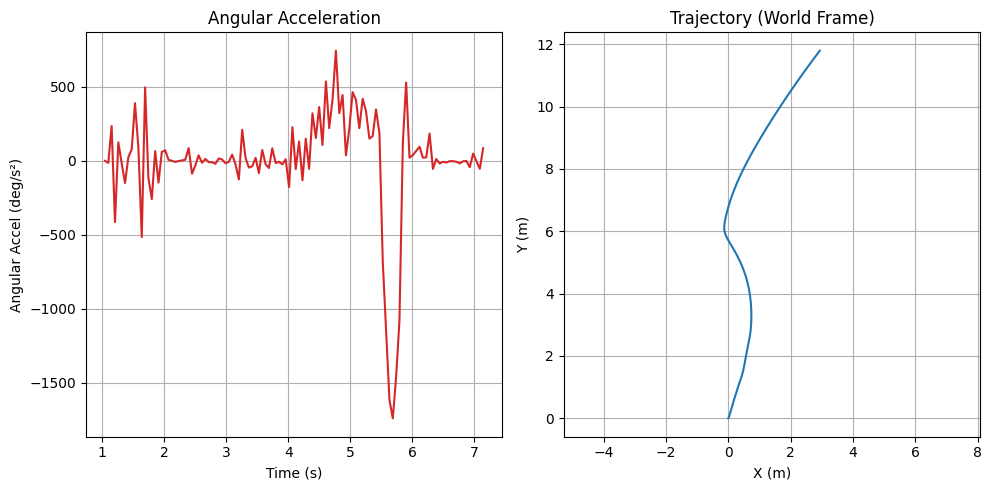

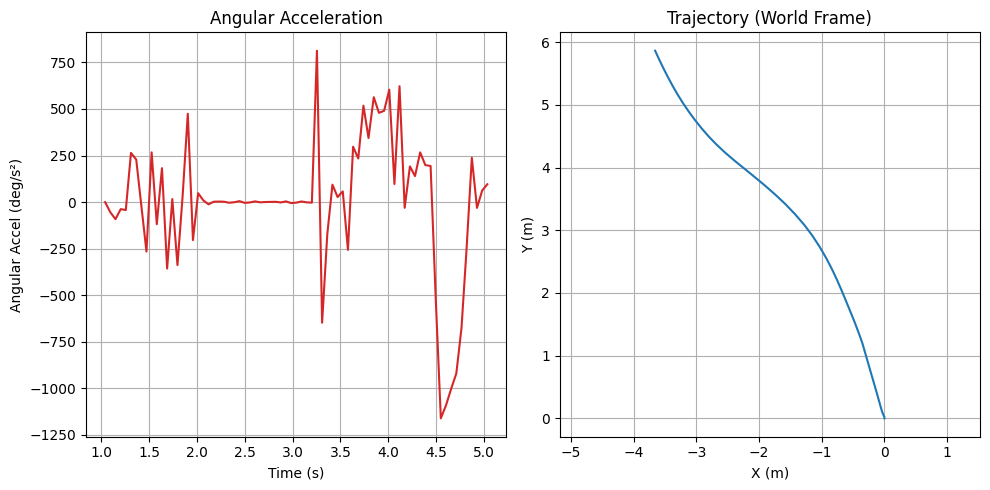

In [ ]:
n = 1
for df_i in dfs_zanos:
    df_new = data_to_world_frame(df_i)
    df_new.to_csv(f'data_in_world_frame/datasets_slide/dataset_raw{n}.csv', index=False)
    n += 1

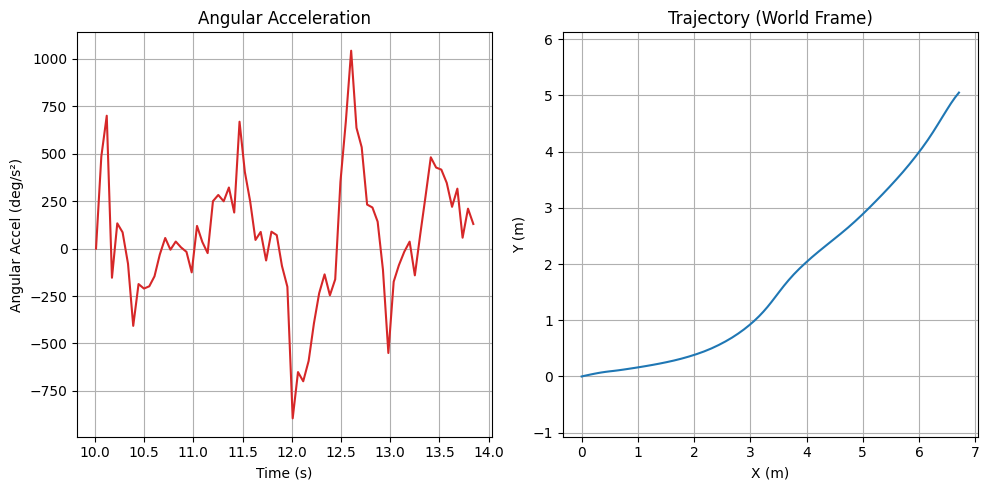

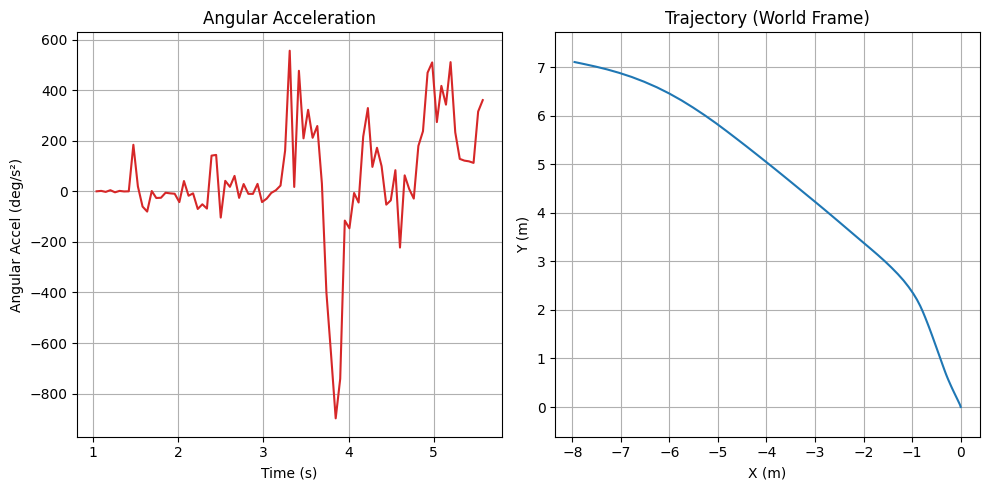

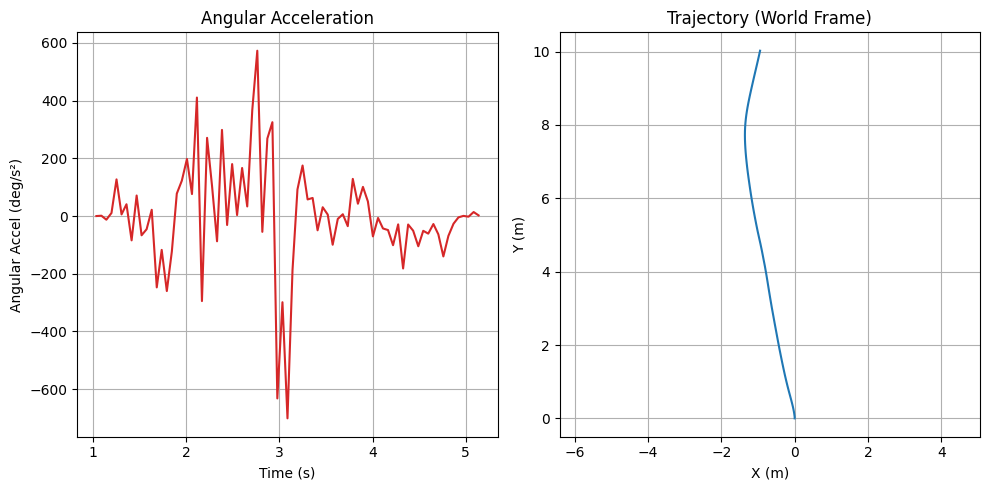

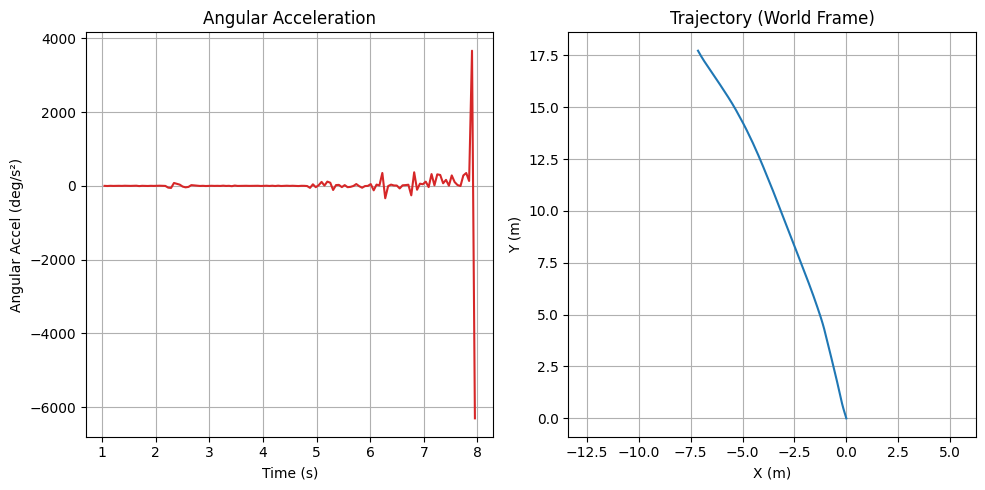

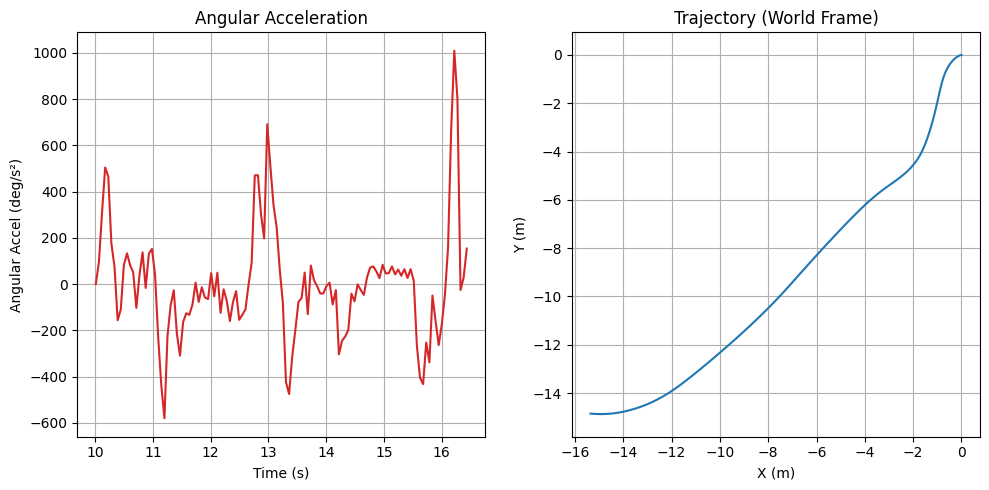

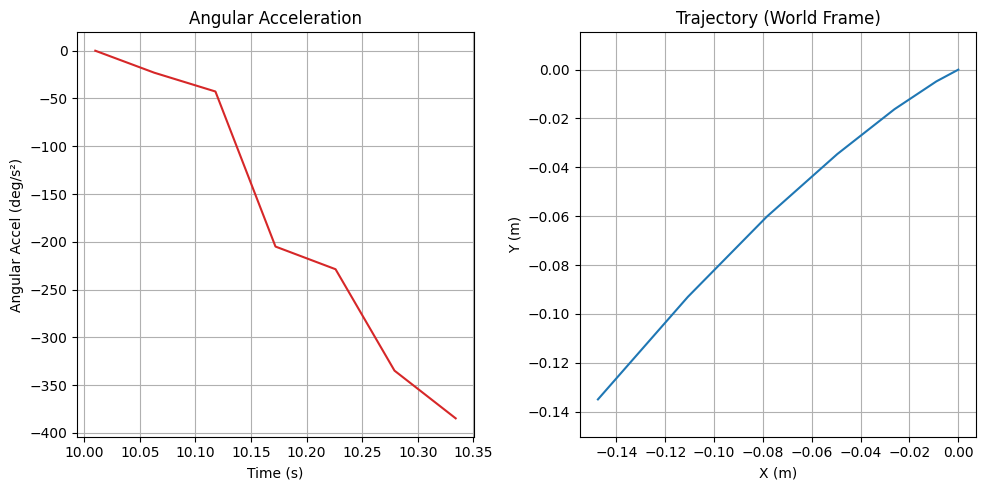

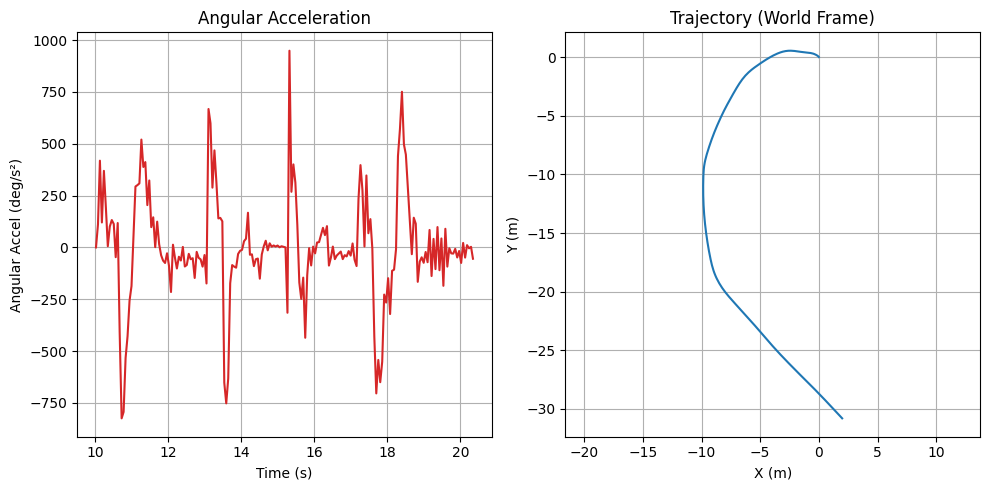

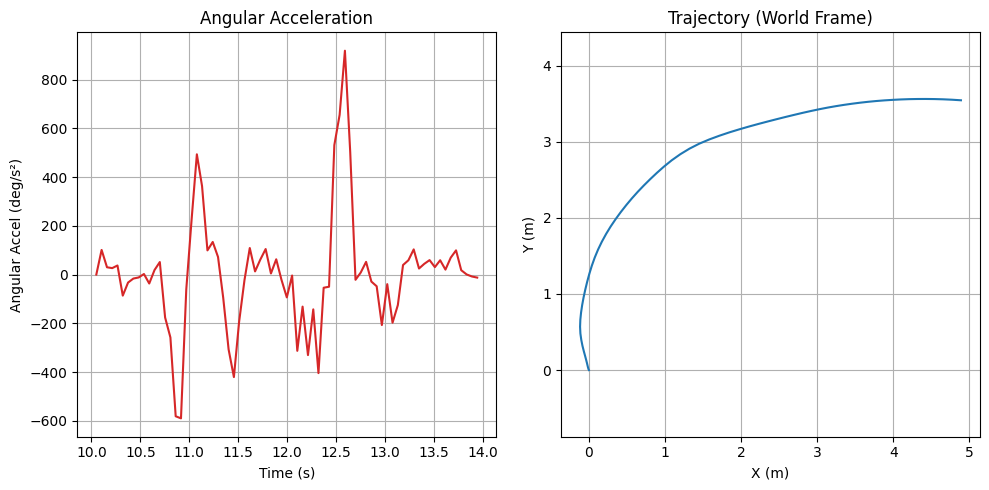

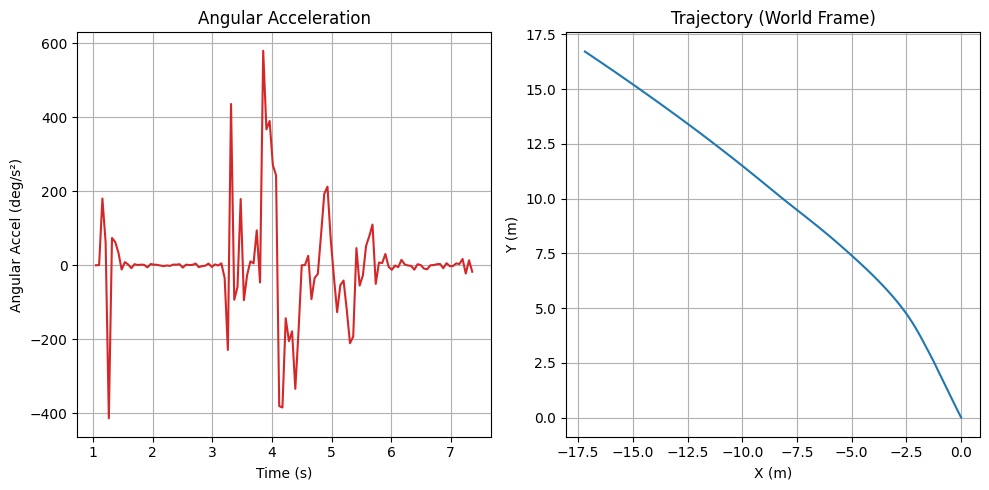

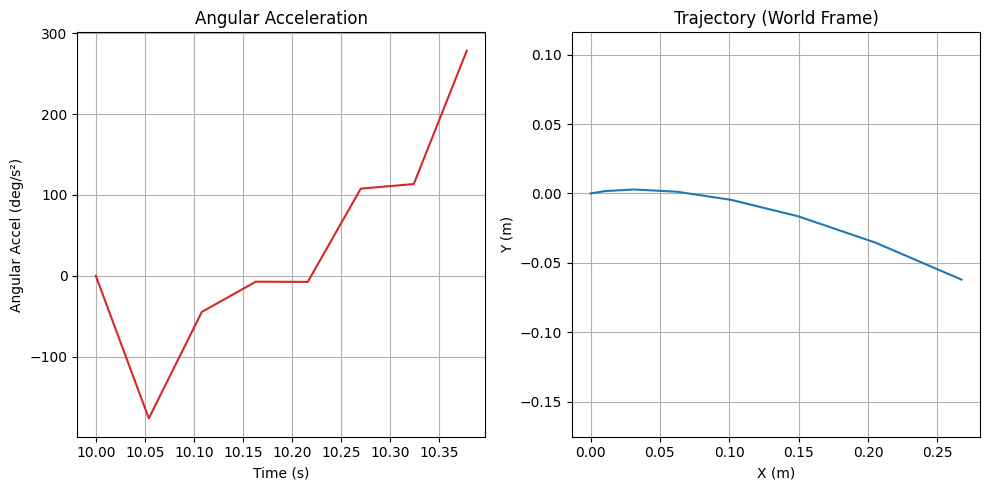

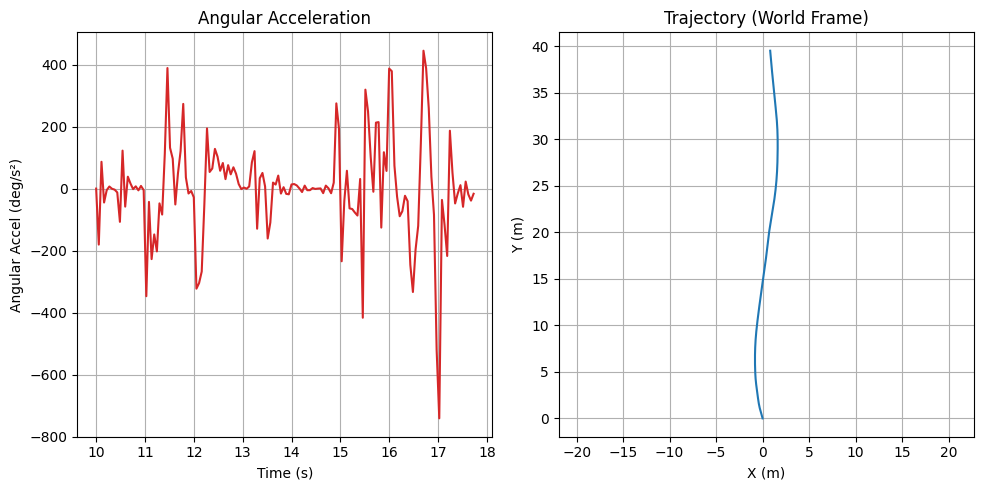

/tmp/ipython-input-25-3592748548.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dt = df["t_sec"].diff().fillna(0.02)  # подставим 20 мс, если NaN
/tmp/ipython-input-25-3592748548.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["angular_accel"] = df["angular_accel"].fillna(0)


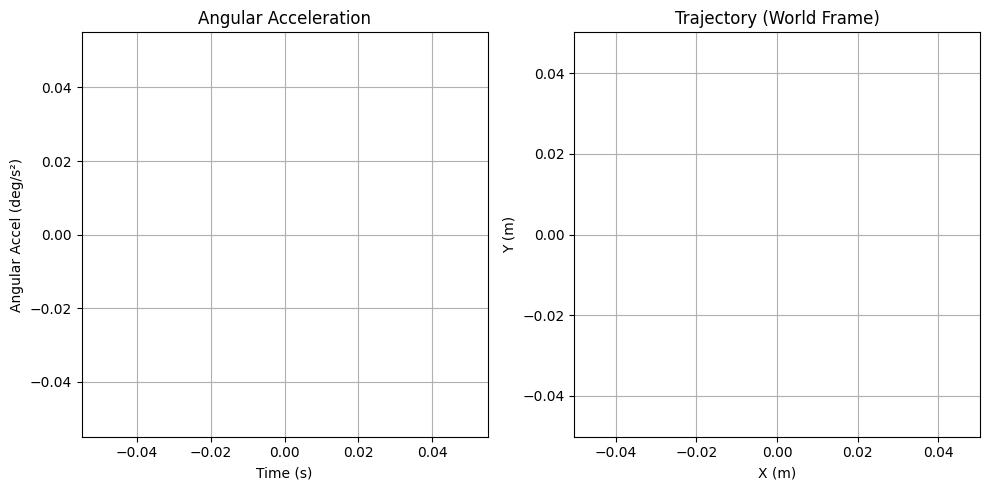

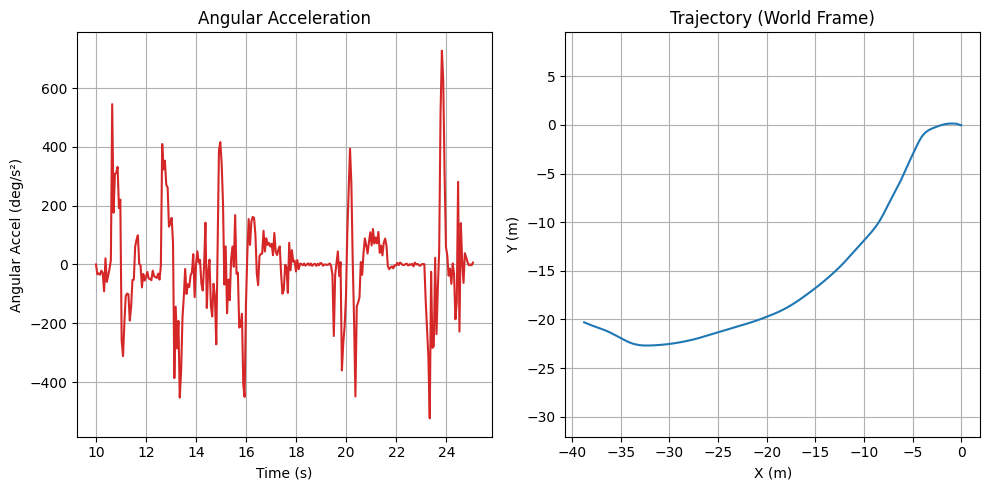

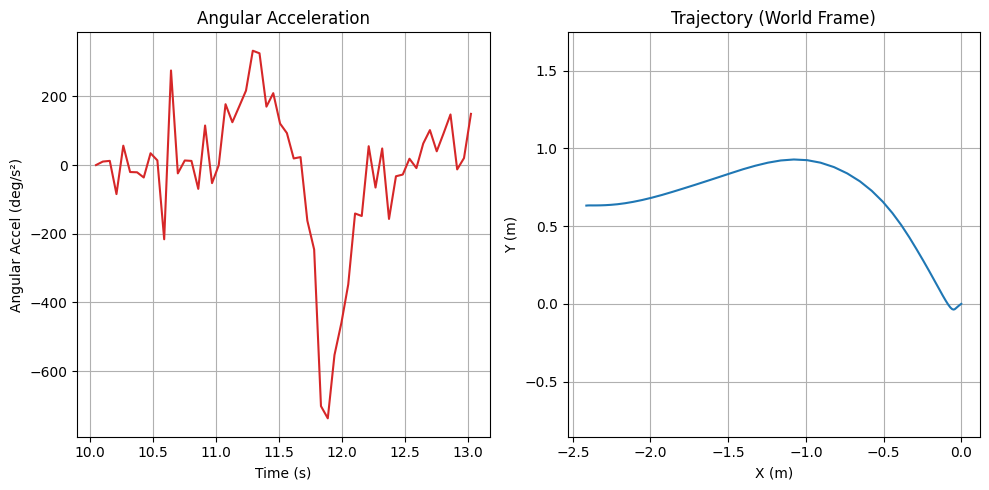

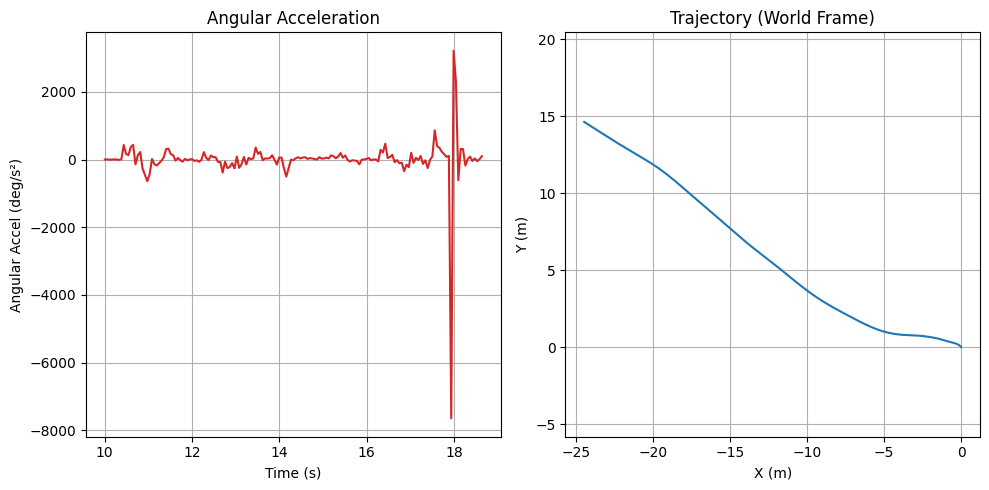

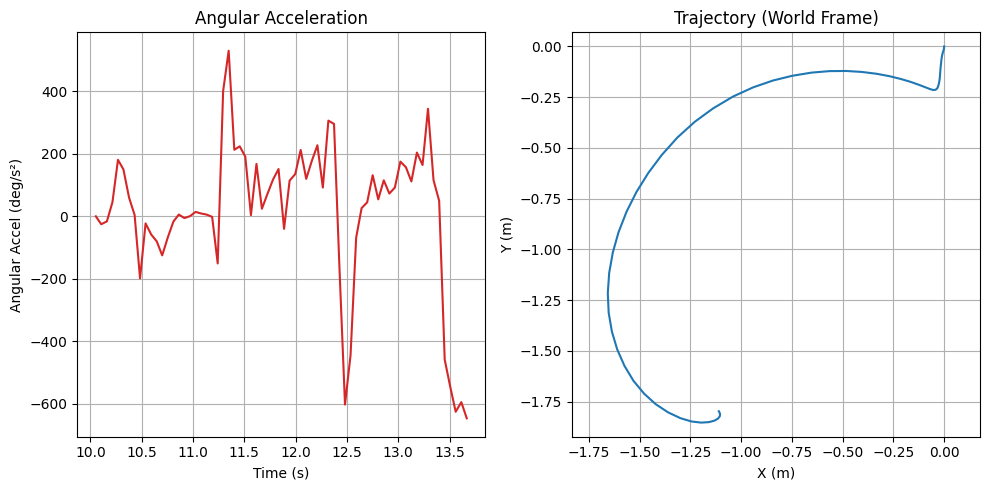

In [ ]:
n = 1
for df_i in dfs_forward:
    df_new = data_to_world_frame(df_i)
    df_new.to_csv(f'data_in_world_frame/datasets_straight/dataset_raw{n}.csv', index=False)
    n += 1

In [ ]:
!zip -r data_in_world_frame.zip data_in_world_frame/

  adding: data_in_world_frame/ (stored 0%)
  adding: data_in_world_frame/datasets_slide/ (stored 0%)
  adding: data_in_world_frame/datasets_slide/dataset_raw10.csv (deflated 53%)
  adding: data_in_world_frame/datasets_slide/dataset_raw15.csv (deflated 53%)
  adding: data_in_world_frame/datasets_slide/dataset_raw9.csv (deflated 53%)
  adding: data_in_world_frame/datasets_slide/dataset_raw11.csv (deflated 53%)
  adding: data_in_world_frame/datasets_slide/dataset_raw13.csv (deflated 54%)
  adding: data_in_world_frame/datasets_slide/dataset_raw14.csv (deflated 53%)
  adding: data_in_world_frame/datasets_slide/dataset_raw4.csv (deflated 52%)
  adding: data_in_world_frame/datasets_slide/dataset_raw12.csv (deflated 19%)
  adding: data_in_world_frame/datasets_slide/dataset_raw7.csv (deflated 53%)
  adding: data_in_world_frame/datasets_slide/dataset_raw1.csv (deflated 53%)
  adding: data_in_world_frame/datasets_slide/dataset_raw6.csv (deflated 53%)
  adding: data_in_world_frame/datasets_slide/d